### Network Builder
This notebook is a step by step in building a heterogeneous graph for our dataset recommendation system. The step by step is in effort to make our graph more well connected, which will be as follows:
1. Load train_test data
2. Load Phase 1 & Phase 2 competition output data
3. Combine data from step 1 & step 2
4. Generate initial graph of `[publication, dataset]` entities
5. Extract & Integrate `Subject Terms` Entity
6. Load & Integrate `Author` Entity
7. Load & Integrate Publication Similarity Edges

In [36]:
import json 
import itertools
import pandas as pd
import seaborn as sns
import networkx as nx
from networkx.readwrite import json_graph

def writeNX(filename, g):
    network_json = json_graph.node_link_data(g)
    json.dump(network_json, open(filename, 'w'), indent=2)
def readNX(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

%matplotlib inline

# 1. Load train_test data

In [2]:
tt_pub = pd.read_json('data/train_test/publications.json')
tt_data = pd.read_json('data/train_test/data_sets.json')
tt_cit = pd.read_json('data/train_test/data_set_citations.json')
tt_cit['source'] = 'train_test'

In [3]:
print('Ratio of publications linked', tt_cit.publication_id.nunique()/tt_pub.shape[0])
print('Ratio of dataset linked', tt_cit.data_set_id.nunique()/tt_data.shape[0])

Ratio of publications linked 0.5
Ratio of dataset linked 0.09934286818708929


# 2. Load Phase 1 + Phase 2 data

In [4]:
p1_pub = pd.read_json('data/phase1_holdout_publications.json')
p2_pub = pd.read_json('data/phase2_holdout_publications.json')

p1_cit = pd.read_json('data/competition-output/phase1-final/rcc-03/raw_results/data_set_citations.json')
p1_cit['source'] = 'phase1'
p2_cit = pd.read_json('data/competition-output/phase2-final/rcc-05/raw_results/holdout/output/data_set_citations.json')
p2_cit['source'] = 'phase2'
p2_cit_wc =  pd.read_json('data/competition-output/phase2-final/rcc-05/raw_results/wc_holdout/output/data_set_citations.json')
p2_cit_wc['source'] = 'phase2_wc'

# 3. Combine data from step 1 & 2

In [5]:
all_pubs = pd.concat([tt_pub, p1_pub, p2_pub]).reset_index(drop=True)
print("Publications", all_pubs.shape[0])
all_data = tt_data
print('Datasets', all_data.shape[0])

all_cit = pd.concat([tt_cit[['publication_id', 'data_set_id', 'score', 'source']], 
                     p1_cit[['publication_id', 'data_set_id', 'score', 'source']], 
                     p2_cit[['publication_id', 'data_set_id', 'score', 'source']],
                     p2_cit_wc[['publication_id', 'data_set_id', 'score', 'source']]]).reset_index(drop=True)
all_cit['pub_name'] = ['pub_'+str(i) for i in all_cit.publication_id] 
all_cit['data_name'] = ['data_'+str(i) for i in all_cit.data_set_id] 

print("Citations", all_cit.shape[0])
print("\tPub-Citation", len(set(all_cit.publication_id)))
print("\tData-Citation", len(set(all_cit.data_set_id)))

Publications 15001
Datasets 10348
Citations 12457
	Pub-Citation 4290
	Data-Citation 1646


# 4. Generate [dataset, publication] graph

In [6]:
G = nx.Graph()

pub_nodes = ['pub_'+str(i) for i in all_pubs.publication_id]
data_nodes = ['data_'+str(i) for i in all_data.data_set_id]
G.add_nodes_from(pub_nodes+data_nodes)

pub_edges = [(x,y) for x,y in zip(all_cit.pub_name, all_cit.data_name)]
G.add_edges_from(pub_edges)

print("Nodes", G.number_of_nodes(), "\nEdges", G.number_of_edges())

Nodes 25367 
Edges 11138


# 5. Extract & Integrate Subject Terms

In [7]:
all_sub = [i.split(',') for i in all_data.subjects]
all_sub = set(list(itertools.chain(*all_sub)))
G.add_nodes_from(all_sub)

sub_edges = [('data_'+str(x),sub) for x,y in zip(all_data.data_set_id, all_data.subjects) for sub in y.split(',')]
G.add_edges_from(sub_edges)

print("Nodes", G.number_of_nodes(), "\nEdges", G.number_of_edges())

Nodes 34083 
Edges 212811


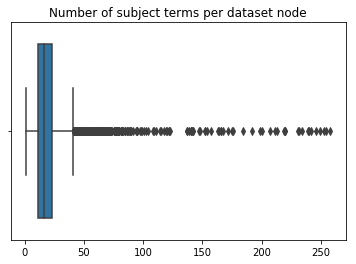

In [8]:
tmp = pd.DataFrame([['data_'+str(x),sub] for x,y in zip(all_data.data_set_id, all_data.subjects) for sub in y.split(',')], columns = ['data_name', 'sub'])
ax = sns.boxplot(tmp.groupby('data_name').size())
ax = ax.set_title('Number of subject terms per dataset node')

# 6. Load & Integrate Author

In [9]:
all_auth = pd.read_csv('data/p1p2_PubAuthor_pairs.csv')[['publication_id', 'AuthorId']]
all_auth = pd.concat([all_auth, pd.read_csv('data/PubAuthor_pairs.csv')[['publication_id', 'AuthorId']]]).reset_index(drop=True)
# display(all_auth[all_auth.publication_id == 5698], all_pubs[all_pubs.publication_id==5698])

In [10]:
auth_nodes = ['auth_'+str(i) for i in list(set(all_auth.AuthorId))]
G.add_nodes_from(auth_nodes)

auth_edges = [('pub_'+str(x),'auth_'+str(y)) for x,y in zip(all_auth.publication_id, all_auth.AuthorId)]
G.add_edges_from(auth_edges)

print("Nodes", G.number_of_nodes(), "\nEdges", G.number_of_edges())

Nodes 73438 
Edges 260720


# 7. Load & Integrate Publication Text Similarity Edges

In [18]:
all_sim = pd.read_csv('data/doc_sim.csv')[['Doc1', 'Doc2', 'Similarity']]

In [33]:
top_sim = all_sim[all_sim.Similarity >= 0.95]

sim_edges = [(x,y) for x,y in zip(top_sim.Doc1, top_sim.Doc2)]
G.add_edges_from(sim_edges)

print("Nodes", G.number_of_nodes(), "\nEdges", G.number_of_edges())
print("\nRatio of newly connected publications: ", len(set(top_sim.Doc1.append(top_sim.Doc2)))/all_pubs.shape[0])


Nodes 73438 
Edges 281084

Ratio of newly connected publications:  0.24231717885474302


# `Export Graph`

In [37]:
writeNX('data/network_v2.0.json', G)